## Prompting bio-image analysis tasks using LangChain
In this notebook we demonstrate how to prompt for executing bio-image analysis tasks using chatGPT and [LangChain](https://github.com/hwchase17/langchain). 

In [1]:
from langchain.memory import ConversationBufferMemory
from langchain.chat_models import ChatOpenAI
from langchain.agents import initialize_agent
from langchain.agents import AgentType
from langchain.tools import tool

from skimage.io import imread
from napari_segment_blobs_and_things_with_membranes import voronoi_otsu_labeling

import stackview

For accomplishing this, we need an image storage. To keep it simple, we use a dictionary.

In [2]:
image_storage = {}

To demonstrate bio-image analysis using English language, we define common bio-image analysis functions for loading images, segmenting and counting objects and showing results.

In [3]:
tools = []

In [4]:
@tools.append
@tool
def load_image(filename:str):
    """Useful for loading and image file and storing it."""
    print("loading", filename)
    image = imread(filename)
    image_storage[filename] = image
    return "The image is now stored as " + filename

In [5]:
@tools.append
@tool
def segment_bright_objects(image_name):
    """Useful for segmenting bright objects in an image that has been loaded and stored before."""
    print("segmenting", image_name)
    
    image = image_storage[image_name]
    label_image = voronoi_otsu_labeling(image, spot_sigma=4)
    
    label_image_name = "segmented_" + image_name
    image_storage[label_image_name] = label_image
    
    return "The segmented image has been stored as " + label_image_name

In [6]:
@tools.append
@tool
def show_image(image_name):
    """Useful for showing an image that has been loaded and stored before."""
    print("showing", image_name)
    
    image = image_storage[image_name]
    display(stackview.insight(image))
    
    return "The image " + image_name + " is shown above."

In [7]:
@tools.append
@tool
def count_objects(image_name):
    """Useful for counting objects in a segmented image that has been loaded and stored before."""
    label_image = image_storage[image_name]
    
    num_labels = label_image.max()
    print("counting labels in ", image_name, ":", num_labels)

    return f"The label image {image_name} contains {num_labels} labels."

We create some memory and a large language model based on OpenAI's chatGPT.

In [8]:
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
llm=ChatOpenAI(temperature=0)

Given the list of tools, the large language model and the memory, we can create an agent.

In [9]:
agent = initialize_agent(
    tools, 
    llm, 
    agent=AgentType.CHAT_CONVERSATIONAL_REACT_DESCRIPTION, 
    memory=memory
)

This agent can then respond to prompts.

loading ../../data/blobs.tif
showing ../../data/blobs.tif


StackViewNDArray([[ 40,  32,  24, ..., 216, 200, 200],
                  [ 56,  40,  24, ..., 232, 216, 216],
                  [ 64,  48,  24, ..., 240, 232, 232],
                  ...,
                  [ 72,  80,  80, ...,  48,  48,  48],
                  [ 80,  80,  80, ...,  48,  48,  48],
                  [ 96,  88,  80, ...,  48,  48,  48]], dtype=uint8)
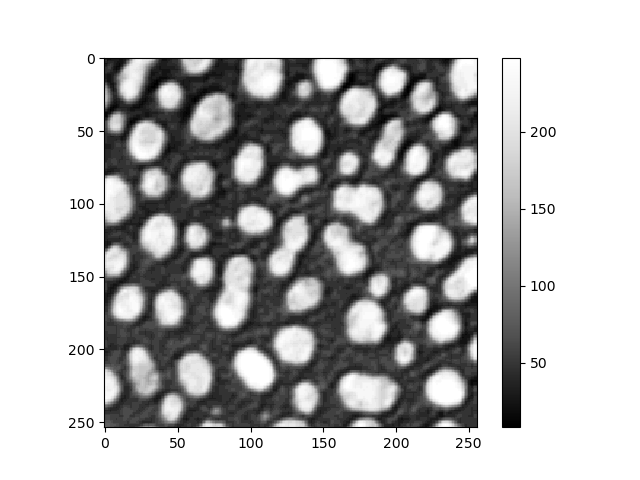
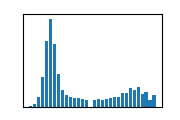

'The image ../../data/blobs.tif is shown above.'

In [10]:
agent.run("Please load the image ../../data/blobs.tif and show it.")

In [11]:
agent.run("Please segment the image ../../data/blobs.tif .")

segmenting ../../data/blobs.tif


'The segmented image has been stored as segmented_../../data/blobs.tif'

showing segmented_../../data/blobs.tif


StackViewNDArray([[0, 0, 0, ..., 4, 4, 4],
                  [0, 0, 0, ..., 4, 4, 4],
                  [0, 0, 0, ..., 4, 4, 4],
                  ...,
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0]])
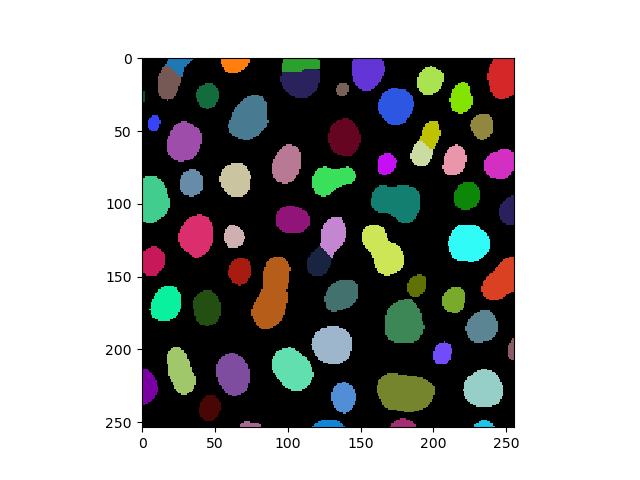

'The segmented image ../../data/blobs.tif is shown above.'

In [12]:
agent.run("Please show the segmented ../../data/blobs.tif image.")

In [13]:
agent.run("How many objects are there in the segmented ../../data/blobs.tif image?")

counting labels in  segmented_../../data/blobs.tif : 64


'The segmented ../../data/blobs.tif image contains 64 objects.'

## Chaining operations
We can also chain these operations in a single sentence and the `agent` will figure out on it's own how to do this.

In [14]:
# empty memory and start from scratch
image_memory = {}

loading ../../data/blobs.tif
segmenting ../../data/blobs.tif
counting labels in  segmented_../../data/blobs.tif : 64
showing segmented_../../data/blobs.tif


StackViewNDArray([[0, 0, 0, ..., 4, 4, 4],
                  [0, 0, 0, ..., 4, 4, 4],
                  [0, 0, 0, ..., 4, 4, 4],
                  ...,
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0]])
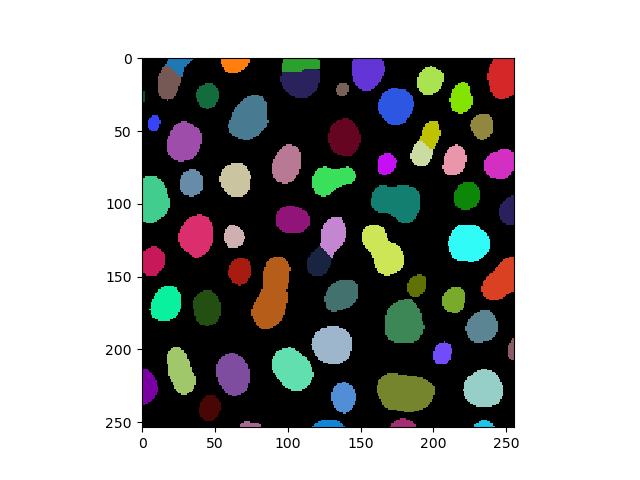

'The segmented image has been shown.'

In [15]:
agent.run("""
Please load the image ../../data/blobs.tif, 
segment bright objects in it, 
count them and 
show the segmentation result.
""")

In [16]:
agent.run("How many objects were there?")

counting labels in  segmented_../../data/blobs.tif : 64


'The segmented image contains 64 objects.'